<div class="report-header"><div class="aictx-logo"></div>
<span class="report-type">Documentation</span><br />
<span class="report-author">Author: Felix Bauer</span><br />
<span class="report-date">26th July, 2019</span>
</div><h1>VirtualDynapse:</h1><h1>Simulate DynapSE chips</h1>

This document illustrates how to use the `VirtualDynapse` class to simulate a DynapSE neuromorphic processor.

##### Housekeeping and import statements


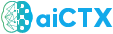

In [1]:
# - Initialisation code to include custom report styles
from IPython.core.display import HTML
def css_styling():
    styles = open("aictx-report.css", "r").read()
    return HTML(styles)
css_styling()

The purpose of the `VirtualDynapse` class is to provide and understanding of which operations are possible with neuromorphic chips such as DynapSE and which constraints may apply. It is not to be seen as a detailled simulation of the underlying circuits. Neuronal dynamics are approximated with the *adaptive exponential integrate-and-fire model* (<a href="http://www.scholarpedia.org/article/Adaptive_exponential_integrate-and-fire_model">AEIF</a>) with <a href="https://www.nest-simulator.org/">NEST</a> as simulation backend. Tuneable parameters are indicative of which aspects of neuron dynamics can be modified but do not correspond directly to paramaters used to configure the actual hardware. Not all possible ways of configuring paramters or synaptic connection may be covered. Mismatch is approximated by drawing individual neuron parameters from a Gaussian distribution with the provided value as mean.

## Hardware

This chapter gives a brief overview over the neuromorphic hardware that this class simulates.

<br> 

### Neuron model
The dynamics of the neurons on a Dynap-SE processor can be approximately described by the adaptive exponential integrate-and-fire model (<a href="http://www.scholarpedia.org/article/Adaptive_exponential_integrate-and-fire_model">AEIF</a>), with spike-triggered adaptation. The resting potential ($E_L$ in the link) is implicitly 0.

<br> 

### Hierarchy
Dynap-SE chips consist of multiple cores, each with a certain number of neurons (e.g. Dynap-SE 1: 4 cores pre chip, 256 neurons per core). Multiple chips can be used together (e.g. Dynap-SE 1 development kit: 4 chips) to implement larger networks. **Neuron parameters are set on a per-core basis,** meaning that all neurons in one core share the same set of parameters. In practice, (mismatch)[#mismatch] ensures that there is still variability in neuron dynamics, even within a core.

<br> 

### Connectivity
For each neuron the number of presynaptic neurons from which it can receive events as well as the number of chips to which a neuron's spikes can be routed are limited. Standard values are guided by the specifications of Dynap-SE 1. For other models these constraints may look different. Furthermore some of the constraints may be circumvented by techniques such as virtual core IDs (see `DynapseControl` documentation for more details), which are not simulated in this class, and connection aliasing.

<br> 

#### Connection aliasing
A postsynaptic neuron cannot distinguish between events from neurons that are from different chips but have the same ID within their respective chip. This also includes external input channels to the neuron. If events from such neurons are routed to the core of the postsynaptic neuron, it will respond to all of them, even if it should only be connected to one.

In practice this means, that situations should be avoided where two neurons on the same core have presynaptic connections to neurons that are on different chips but have same IDs within their chips. The `VirtualDynapse` class will warn or raise an exception in such cases.

However, connection aliasing can also be used to increase the fan-in of a neuron, in particular in conjunction with virtual core IDs.

<br> 

### <a name="mismatch"></a>Mismatch
Due to the analog nature of the silicon neurons and their device mismatch, temporal and functional characteristics vary between individual neurons and synapses. This intrinsic inhomogeneity is usually exploited to introduce variability in neuron parameters and enhance signal dimensionality. The `VirtualDynapse` class can include mismatch in its simulations.

## Using the class

<br> 

### Setup

The class can be imported from the `rockpool` package:



In [3]:
# - Import VirtualDynapse class
from rockpool.layers import VirtualDynapse

There may be warnings that some packages could not be loaded. In most cases those packages are not required and the warnings may be ignored.

#### Hardware parameters

Parameters that are inherent to the simulated hardware can be set in a separate `params.py` module. Default values correspond to the DynapSE 1.

| Parameter | Type | Meaning | Default|
|-----------|------|---------|--------|
| `CORE_DIMENSIONS` | `Tuple[int, int]` | Number of neurons per row and per column in a single core. | `(16, 16)` |
| `NUM_CORES_CHIP` | `int` | Number of cores per chip. | `4` |
| `NUM_CHIPS` | `int` | Number chips being used. | `4` |
| `NUM_CAMS_NEURON` | `int` | Number of CAM cells per neuron. Corresponds to fan-in of a neuron. | `64` |
| `NUM_SRAMS_NEURON` | `int` | Number of SRAM cells per neuron. Corresponds to number of postsynaptic cores of a neuron. | `3` |
| `BIT_RESOLUTION_WEIGHTS` | `int` | Resolution of weights in bits. `n` bits correspond to weights from `0` to `2**n - 1`. | `1` |
| `STDDEV_MISMATCH` | `float` | Standard deviation of Gaussian distribution for mismatched parameters (relative to mean). | `0.2` |

Note that of the four SRAM cells of a neuron on Dynap-SE 1, one is used to monitor the firing activity, which leaves three for routing events to different chips. If this is not needed, the value for `NUM_SRAMS_NEURON` can be increased to 4. 

From these parameters a few values are derived that are widely used by the `VirtualDynapse` class:

| Parameter | Type | Meaning | Default|
|-----------|------|---------|--------|
| `num_neurons_chip` | `int` | Number of neurons per chip. | `1024` |
| `num_neurons` | `int` | Total number of available neuorns. | `4096` |
| `num_cores` | `int` | Total number of available cores. | `16` |
| `weight_resolution` | `int` | Maximum weight for synaptic connections. | `1` |

#### Instantiation

Many arguments can be passed to the `VirtualDynapse` constructor (see below) but it is also possible to create an instance without any arguments . This way it is instantiated with standard parameters and without any synaptic connections. Parameters and connections can then be modified later on. Only the simulation time step `dt` can not be changed (default: 0.1 ms).

In [4]:
# - Create VirtualDynapse instance
vd = VirtualDynapse()

VirtualDynapse 'unnamed':  Ready.


##### Arguments

The following optional arguments can be passed during object instantiation:

| Argument | Type | Default | Meaning |
|----------|------|---------|---------|
| `dt` | `float` | `1e-4` | Simulation time step |
| `connections_ext` | 2D-`ndarray`| `None` | Connections to external inputs. |
| `connections_rec` | 2D-`ndarray` | `None` | Connections between neurons. |
| `tau_mem_1` | `float` or list-like | `0.02` | Membrane time constant 1 for each core (in seconds). |
| `tau_mem_2` | `float` or list-like | `0.02` | Membrane time constant 2 for each core (in seconds). |
| `has_tau_mem_2` | `bool` or list-like | `False` | Individual neurons have membrane time constant 2.  |
| `tau_syn_exc` | `float` or list-like | `0.05` | Time constant of excitatory synapses on each core (in seconds). |
| `tau_syn_inh` | `float` or list-like | `0.05` | Time constant of inhibitory synapses on each core (in seconds). |
| `baseweight_e` | `float` or list-like | `0.01` | Base weight for excitatory synapses on each core. |
| `baseweight_i` | `float` or list-like | `0.01` | Base weight for inhibitory synapses on each core. |
| `bias` | `float` or list-like | `0.0` | Constant current input on each core. |
| `refractory` | `float` or list-like | `0.001` | Refractory period for each core (in seconds). |
| `v_thresh` | `float` or list-like | `0.01` | Spiking threshold for each core. |
| `spike_adapt` | `float` or list-like | `0.0` | Scaling for spiking triggered adaptation. |
| `delta_t` | `float` or list-like | `0.002` | Scaling for exponential part of activation function. |
| `name` | `str` | `"unnamed"` | Layer name. |
| `num_threads` | `int`| `1` | Number of available CPU cores for multiprocessing. |
| `mismatch` | `bool` or 2D-`ndarray`| `True` | Enable or disable mismatch or pass explicit mismatch factors. |
| `record` | `bool` | `False` | Record membrane potentials during state evolution. |

Most parameters can be set for each core. In these cases it is possible to provide either a single value that is applied to all, or a list-like of length `num_neurons_core` with individual values for each core. Parameters that are not set core-wise are the connections between neurons, `has_tau_mem_2` (neuron-wise) as well as class settings like the simulation time step `dt` and `num_threads`.

* The simulation time step `dt` cannot be changed after instantiation.
* The number of connections from external inputs to each neuron are defined in a 2D-`np.ndarray` `connections_ext`. Its size can be at most `num_neurons_chip` x `num_neurons`. Smaller arrays will be zero-padded. If `None` is passed (default), no connections will be set.
* The number of connections from between each pair of neurons are defined in a 2D-`np.ndarray` `connections_rec`. Its seize can be at most `num_neurons` x `num_neurons`. Smaller arrays will be zero-padded. If `None` is passed (default), no connections will be set.
* For each core two membrane time constants can be set with `tau_mem_1` and `tau_mem_2`. Each individual neuron can be assigned either the first or second time constant of its core. This is defined in `has_tau_mem_2`, which can either be a list-like of `bool`s with length `num_neurons` or a `bool`(same for all neurons). `True` means the corresponding neuron uses `tau_mem_2`.
* Time constants for excitatory and inhibitory synapses can be set in `tau_syn_exc` and `tau_syn_inh`, respectively.
* Baseweights are multiplied with the number of connections for each neuron pair to get the effective weight. They are set for excitatory and inhibitory synapses in `baseweight_e` and `baseweight_i`, respectively.
* Constant input currents (biases) can be defined in `bias`. 
* Refractory times can be defined in `refractory`.
* Firing thresholds are defined in `v_thresh`. Reset and resting potentials are implicitly `0`.
* The scale and time constants of spike triggered adaptation can be defined in `spike_adapt` and `tau_adapt`.
* The exponential part of the actiavtion function can be scaled with `delta_t`.
* Each instance can be given a `name`.
* The NEST backend can be particularly fast if run in multiple processes. `num_threads` sets the number of available threads for this instance.
* The parameter `mismatch` can either be a `bool` or a 2D-`np.ndarray` of size (12 + 2 * `num_neurons`) x `num_neurons`. In the first case mismatch is either enabled or discabled. The second case is used to provide specific mismatch factors (see .....) for each parameter and neuron, for example to reconstruct another instance precisely. The rows of the array correspond to the following parameters in ascending order: `baseweight_e`, `baseweight_i`, `bias`, `refractory`, `tau_mem_1`, `tau_mem_2`, `tau_syn_exc`, `tau_syn_inh`, `v_thresh`, `spike_adapt`, `tau_adapt`, `delta_t`, `weights_exc`, `weights_rec`.

### Core parameters and mismatch

Parameters for tuning network dynamics are set for each core. They can be accessed as attributes of the `VirtualDynapse` instance. To change them it is possible to provide anything that can be broadcast to a 1D-array of size `num_cores`. All parameters must have nonnegative values, which will be clipped to zero otherwise.

Values for individual neurons can be accessed (but not changed directly) by appending an underscore at the end of the attribute. Those values will include the mismatch, which is different for each neuron.

In [5]:
print("Before:")
print("Excitatory baseweight: ", vd.baseweight_e)
print("Refractory period: ", vd.refractory)
print("Excitatory synapse time constant: ", vd.tau_syn_exc)
print("Bias: ", vd.bias, "\n")

# - Change a few neuron parameters
vd.baseweight_e = 2 * [0.01] + 14 * [0.02] # Pass array-like of correct size
vd.refractory = 0.02  # Pass scalar value
vd.tau_syn_exc *= 2
vd.bias[1] = 0.01

print("After:")
print("Excitatory baseweight: ", vd.baseweight_e)
print("Refractory period: ", vd.refractory)
print("Excitatory synapse time constant: ", vd.tau_syn_exc)
print("Bias: ", vd.bias, "\n")

print("Refractory period for first four neurons, including mismatch:")
print(vd.refractory_[:4])

Before:
Excitatory baseweight:  [0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.01
 0.01 0.01]
Refractory period:  [0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001 0.001
 0.001 0.001 0.001 0.001]
Excitatory synapse time constant:  [0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05 0.05
 0.05 0.05]
Bias:  [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 

After:
Excitatory baseweight:  [0.01 0.01 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02]
Refractory period:  [0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02 0.02
 0.02 0.02]
Excitatory synapse time constant:  [0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
Bias:  [0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
 0.   0.  ] 

Refractory period for first four neurons, including mismatch:
[0.01547135 0.02124197 0.02170358 0.01447434]


#### Mismatch

To simulate device mismatch, for each neuron and each parameter a value is drawn from a Gaussian with mean 1 and standard deviation `STDDEV_MISMATCH`. Those values, which are constant over time, are multiplied with the parameters of the cores to obtain mismatched individual neuron parameters.

#### Membrane time constants

For every core there are two membrane time constants and each neuron can be individually assigned one of them. This is done by the parameter `has_tau_mem_2`, which is a boolean array of size `num_neurons` and `True` for each neuron that is assigned `tau_mem_2`. The current time constants per neuron can be read out (but not changed directly) through the `tau_mem_` attribute.

In [6]:
# - Set membrane time constants for first chip
vd.tau_mem_1 = 0.03
vd.tau_mem_2 = 0.08

# - Set neurons 0 and 3 to use tau_mem_2:
vd.has_tau_mem_2[[0, 3]] = True
print(vd.tau_mem_[:4])

RecAEIFSpkInNest `unnamed_nest_backend`: `tau_mem` has been updated by modifying `capacity` (`capacity` = `tau_mem` * `conductance`).
RecAEIFSpkInNest `unnamed_nest_backend`: `tau_mem` has been updated by modifying `capacity` (`capacity` = `tau_mem` * `conductance`).
RecAEIFSpkInNest `unnamed_nest_backend`: `tau_mem` has been updated by modifying `capacity` (`capacity` = `tau_mem` * `conductance`).
[0.07100698 0.03285107 0.03139621 0.08383494]


### Connections and weights

Between each pair of a pre- and a postsynaptic neuron synaptic connections  can be established. Each connection can be assigned an integer weight between 0 and `weight_resolution` (default: 1). Multiple connections can be set to increase the number of weights. However, each connection counts to the fan-in of the postsynaptic neuron, which is limited.

In the `VirtualDynapse` class connections between neurons are defined in a  2D array `connections_rec`, which is of size `num_neurons` x `num_neurons`. The first axis corresponds to presynaptic, the second to postsynaptic neurons. The values correspond to the sum of the integer weights for each connection between the pair. The sign determines whether a connection is excitatory (+) or inhibitory (-).

For example, if there should be an excitatory connection from neuron 1 to neuron 0 with weight 3 and one with weight 2 (assuming `weight_resulution` is greater or equal to 3), `connections_rec[2, 0]` would be set to 5.

The effective weights are then obtained by multiplying the number of connections with the excitatory or inhibitory baseweight (`baseweight_e` / `baseweight_i`) of the postsynaptic neuron and a mismatch value for each pair of neurons. The resulting weight matrix can be accessed (but not changed) through the attribute `weights_rec`.

Weights for connections between specific neuron populations can be easily read out with the `get_weights` method.

<br>

#### External inputs
Connections from external input channels to neurons work the same way as inter-neuron connections. The corresponding connection and weight matrices  are `connections_ext` and `weights_ext`. They are of shape `num_neurons_chip` x `num_neurons` because at most `num_neurons_chip` external input channels are possible. Baseweights remain the same.

<br>

#### Setting connections

Connections can be set at object instantiation by passing the corresponding weight matrices as arguments or with the `set_connections` method, which has the following signature:

Apart from changing the complete connectivity matrix, it is possible to update connections for only a subset of the neurons, by passing the IDs of the pre- or postsynaptic neurons as `ids_pre` or `ids_post` arguments. Their dimensions must match those of the `connections` matrix. If the flag `add` is `False`, corresponding entries in the full connectivity matrix will be replaced by the new values, otherwise they will be added. Connections to external input channels can be set by setting `external` to `True`.

In [7]:
import numpy as np

connections_ext = np.random.randint(-3, 4, size=(4, 3))
connections = np.random.randint(-3, 4, size=(3, 5))

# - Setting connections to external channels
vd.set_connections(
    connections=connections_ext,
    ids_pre=[0,1,2,3],
    ids_post=[4,6,7],
    external=True,
)

# - Setting connections between neurons
vd.set_connections(
    connections=connections,
    ids_pre=[4,6,7],
    ids_post=[6,7, 9, 11, 12],
    external=False,
)

VirtualDynapse 'unnamed': Testing provided connections:
	Connections ok.
VirtualDynapse 'unnamed': Testing provided connections:
	Connections ok.


Alternatively, connections can be changed through item assignment by accessing the connectivity matrices as attributes.

In [8]:
# - Change connections through item assignment
vd.connections_rec[4,3] = 2

VirtualDynapse 'unnamed': Testing provided connections:
	Connections ok.


Either way the class will verify that the new connections are compatible with the constraints of the hardware (limits in fan-in and fan-out) and if connection aliasing occurs. Connections can also be tested without setting them, through the `validate_connections` method. Here, it can be chosen which types of constraints should be tested. 

When updating connections, all constraints are tested by default. To alter this behavior, you can change the boolean attributes `validate_fanin`, `validate_fanout`, `validate_aliasing`.

In [9]:
# - Do not test for connection aliasing anymore
vd.validate_aliasing = False

### Simulation

Simulations can be run by calling the `evolve` method. It has the following signature:

The first argument, `ts_input`, is a `TSEvent` (event-based time series) with the external input spikes. If it is `None`, the input is assumed to be silent. Its channel IDs can be mapped to different IDs for the external input by setting them in the `ids_in` argument.

By how much simulation time the neurons evolve is determined by the duration of `ts_input` (if not `None`), by the argument `duration` or by `num_timesteps` (with increasing priority if muliple arguments are set). If `num_timesteps` is set, this value will be multiplied by the time step size `dt` to obtain the simulation time. 

After simulation the method will return a new `TSEvent` object with  spike trains of the neurons during simulation. They can be filtered to only contain events from specific neurons by setting them in the `ids_out` argument. The IDs of the neurons can be mapped to a continuous sequence of integers starting from 0 (e.g. [1,6,3] -> [0,2,1]), by setting `remap_out_channels` to `True`.

You can verify that the simulation has evolved by the required time by comparing the `t` (current simulation time) before and after calling the `evolve` method. Current neuron membrane potentials can be accessed with the `state` attribute.

If at instantiation the `record` flag was set to `True`, the class will also record neuron membrane potentials during evolution. A `TSContinuous` object with the states from the lates simulation run can be accessed through the `recorded_states` attribute.

### Saving configuration to file

The current configuration of a `VirtualDynapse` isntance, including connections, neuron parameters and mismatch, can be stored to a json file with the `save_layer` method. It can then be loaded with the class method `load_from_file`:

In [10]:
# - Store configuration in file
vd.save_layer("test")

# - Load identical configuration
vd_new = VirtualDynapse.load_from_file("test")

VirtualDynapse 'unnamed': Testing provided connections:
	Connections ok.
VirtualDynapse 'unnamed':  Ready.


### Simplifications

The `VirtualDynapse` class should provide a realistic idea of which configurations are possible with the Dynap-SE processor. Nevertheless a few simplifications have been made that are stated in the following. Should you require any of the below-mentioned features to be implemented in more detail, please contact aiCTX AG.

* __Neuron model:__<br />
The adaptive exponential integrate-and-fire model that is used in simulations is only an approximation of the dynamics of the underlying circuits. Also mismatch is only approximate. For most network architectures it is a suitable compromise between computational efficiency and accuracy. Should you need more precise simulations, however, you may consider the <a href="https://teili.readthedocs.io/en/latest/index.html">teili</a> toolbox, which provides more detailed equaitons.

* __Synapse types:__<br />
On the DynapSE there are four different synapse types which implement different types of excitation and inhibition (e.g. shunting inhibition or NMDA receptors) and provide additional sets of possible synaptic time constants and baseweights per core. For compatibility with the underlying simulation engine this has been simplified to simply two synapse types: excitatory and inhibitory. Furthermore, in reality a pair of neurons could be connected through different synapse types simultaneously, allowing for additional ways of modifying network dynamics. This is currently not possible in this simulation.

* __Baseweights:__<br />
For chips with higher weight resolutions than 1, each bit comes with its own baseweight. In the simulations it is assumed that weights are equidistant.

* __Virtual core IDs:__<br />
It is possible to circumvent some of the connectivity constraints by the use of virtual core IDs. This is currently not supported by the `VirtualDynapse` class.

* __N:__<br />
On the hardware network dynamics are tuned by setting circuit biases. These biases can be compared to the neuron parameters that are used in this simulation but there is no exact correspondence. Still this class provides a good idea of which aspects of the neuron dynamics can be modified, although in practice this might require adjustment of multiple interconnected bias parameters.

### Method overview

`set_connections` <br>
Set connections between specified neuron populations. Verify that connections are supported by hardware.

`validate_connections` <br>
Check whether connections are compatible with constraints of the hardware.

`get_weights` <br>
Return weights between specified neuron populations.

`to_dict` <br>
Return all parameters needed to reconstruct this `VirtualDynapse` instance as a dict.

`load_from_dict` <br>
Class method. Reconstruct a `VirtualDynapse` instance from dict.

`save` <br>
Save configuration from dict (e.g. from `to_dict` method) to file.

`save_layer` <br>
Save all parameters needed to reconstruc this `VirtualDynapse` instance to a json file.

`load_from_file` <br>
Class method. Reconstruct a `VirtualDynapse` instance from json file.

`evolve` <br>
Simulate with given input for given time.

`reset_state` <br>
Reset neuron states.

`reset_all` <br>
Reset neuron states and internal time.



### Attribute overview

<br>

#### Connections and weights
`connections_rec`<br>
Inter-neuron connections.

`connections_ext`<br>
Connections to external input channels.

`weights_rec`*<br>
Effective weight matrix for inter-neuron connections (including baseweights per core).

`weights_ext`<br>
Effective weight matrix for connections to external inputs (including baseweights per core).

`baseweight_e`<br>
Baseweights for excitatory connections per core.

`baseweight_i`<br>
Baseweights for inhibitory connections per core.

<br> 

#### Neuron parameters

`bias` <br>
Bias settings per core.

`bias_`* <br>
Individual bias values for each neuron, including mismatch.

`refractory` <br>
Refractory time settings per core.

`refractory_`* <br>
Individual refractory times for each neuron, including mismatch.

`v_thresh` <br>
Firing threshold settings per core.

`v_thresh_`* <br>
Individual firing thresholds each neuron, including mismatch.

`delta_t` <br>
Scaling of exponental part of neuron activation per core.

`delta_t_`* <br>
Individual scaling values for exponential part of activation function for each neuron, including mismatch.

`spike_adapt` <br>
Adaptation strength settings per core.

`spike_adapt_`* <br>
Individual adaptation strengths for each neuron, including mismatch.

`tau_adapt` <br>
Adaptation time constant settings per core.

`tau_adapt_`* <br>
Individual adaptation time constants values for each neuron, including mismatch.

`tau_mem_I` <br>
Settings for membrane time constant I per core.

`tau_mem_II` <br>
Settings for membrane time constant II per core.

`has_tau_mem_II` <br>
Boolean array, `True` for each neuron that uses membrane time constant II.

`tau_mem_`* <br>
Individual membrane time constants for each neuron, including mismatch.

`tau_syn_exc` <br>
Excitatory synapse time constant settings per core.

`tau_syn_exc_`* <br>
Individual excitatory synapse time constants for each neuron, including mismatch.

`tau_syn_inh` <br>
Inhibitory synapse time constant settings per core.

`tau_syn_inh_`* <br>
Individual inhibitory synapse time constants for each neuron, including mismatch.

<br>

#### Hardware parameters

`size`*, `num_neurons`*<br>
Total number of neurons.

`num_neurons_core`*<br>
Number of neurons per core.

`num_neurons_chip`*<br>
Number of neurons per chip.

`num_cores`*<br>
Total number of cores.

`num_cores_chip`*<br>
Number of cores per chip.

`num_chips`*<br>
Total number of chips.

`size_in`, `num_external`*<br>
Maximum number of external input channels.

`weight_resolution`*<br>
Highest integer weight per connection.

`stddev_mismatch`*<br>
Standard deviation of device mismatch.

`mismatch_factors`*<br>
Factors that are multiplied to core parameters to obtain individual neuron values with mismatch.

<br>

#### Settings and class properties

`dt`*<br>
Simulation time step in seconds.

`record`*<br>
Record neuron membrane potentials during evolution.

`num_threads`*<br>
Number of threads to be used for multiprocessing.

<br>

#### Properties regarding current state

`t`*<br>
Current simulation time in seconds.

`state`<br>
Current neuron membrane potentials.

`recorded_states`*<br>
Neuron membrane potentials recorded during previous simulation.

*: Read-only attributes

#### Colophon
Live notebook requires a Jupyter Notebook server.

GitLab repository location: https://gitlab.com/ai-ctx/network-architectures/blob/master/Projects/Documentation/FFCLIAF%20and%20RecCLIAF.ipynb